In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

data_path = "./dataset/datasetTC4.dat"

data = np.loadtxt(data_path)
print(data.shape)
data

(310, 6)


array([[ 63.03,  22.55,  39.61,  40.48,  98.67,  -0.25],
       [ 39.06,  10.06,  25.02,  29.  , 114.41,   4.56],
       [ 68.83,  22.22,  50.09,  46.61, 105.99,  -3.53],
       ...,
       [ 61.45,  22.69,  46.17,  38.75, 125.67,  -2.71],
       [ 45.25,   8.69,  41.58,  36.56, 118.55,   0.21],
       [ 33.84,   5.07,  36.64,  28.77, 123.95,  -0.2 ]])

In [169]:
# Inicialização dos parâmetros
Kmax = 10 # Número de protótipos
epochs = 20 # Número de iterações
rounds = 30 # Número de rodadas

In [170]:
# Batch K-means
def kmeans(data, proto, epochs):
    N, p = data.shape
    K = proto.shape[0]
    SSD = np.zeros(epochs)

    updt_proto = np.copy(proto)
    
    for epoch in range(epochs):
        dist = np.zeros((N, K))
        for t in range(N):
            dist[t, :] = np.linalg.norm(data[t, :] - updt_proto, axis=1)
        
        cluster = np.argmin(dist, axis=1)
        SSD[epoch] = np.sum(np.min(dist, axis=1)**2)

        for k in range(K):
            I = np.where(cluster == k)[0]
            partition = data[I, :]
            updt_proto[k, :] = np.mean(partition, axis=0)

    return updt_proto, SSD

best_prototypes, best_final_prototypes, best_ssds, best_chs, best_dbs = [], [], [], [], []
for K in range(2, Kmax+1):
    # Aplicando K-médias nos dados por rodada
    rnd_prototypes, rnd_final_prototypes, rnd_ssds = [], [], []
    for rnd in range(rounds):
        idxs = np.random.choice(data.shape[0], K, replace=False) # Aleatoriedade dos protótipos
        prototypes = data[idxs, :] # Protótipos definidos
        rnd_prototypes.append(prototypes)
        
        prototypes, kmeans_SSD = kmeans(data, prototypes, epochs) # Aplicando o K-means
        
        rnd_final_prototypes.append(prototypes)
        rnd_ssds.append(kmeans_SSD)
    
    k_best_ssd_idx = np.argmin([ssd[-1] for ssd in rnd_ssds]) # Pega o índice da rodada com menor SSD final
    
    k_best_prototypes = rnd_prototypes[k_best_ssd_idx]
    k_best_final_prototypes = rnd_final_prototypes[k_best_ssd_idx]
    k_best_ssd = rnd_ssds[k_best_ssd_idx]

    labels = np.argmin(cdist(data, k_best_final_prototypes), axis=1) # Cálcula as labels (clusters) de cada amostra
    ch_index = calinski_harabasz_score(data, labels) # Índice de Calinski-Harabasz
    db_index = davies_bouldin_score(data, labels) # Índice de Davies-Bouldin

    best_prototypes.append(k_best_prototypes) # Salvando os protótipos iniciais da melhor rodada de K
    best_final_prototypes.append(k_best_final_prototypes) # Salvando os protótipos finais da melhor rodada de K
    best_ssds.append(k_best_ssd) # Salvando a curva de SSD da melhor rodada de K
    best_chs.append(ch_index) # Salvando o Índice de Calinski-Harabasz de K
    best_dbs.append(db_index) # Salvando o Índice de Davies-Bouldin de K

best_ch_idx = np.argmax(best_chs) # Melhor K segundo o Índice de Calinski-Harabasz
best_ch = best_chs[best_ch_idx] # Melhor Índice de Calinski-Harabasz

best_db_idx = np.argmin(best_dbs) # Melhor K segundo o Índice de Davies-Bouldin
best_db = best_dbs[best_db_idx] # Melhor Índice de Davies-Bouldin

print("Best Calinski-Harabasz Index: {} (K = {})".format(best_ch, best_ch_idx+2))
print("Best Davies-Bouldin Index: {} (K = {})".format(best_db, best_db_idx+2))

Best Calinski-Harabasz Index: 256.5312773299608 (K = 4)
Best Davies-Bouldin Index: 0.8200532637445763 (K = 4)


Best K = 4
Best SSD = 220623.2505943328


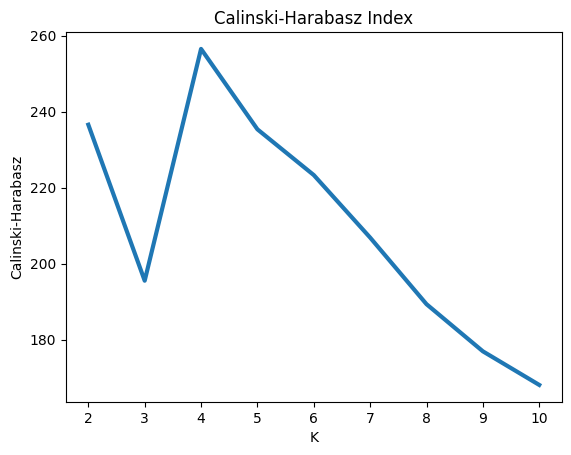

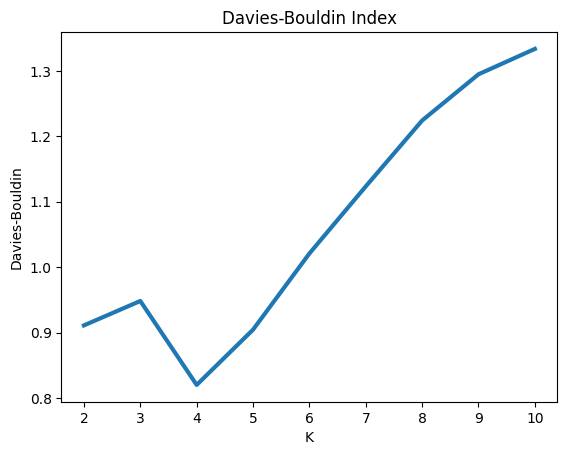

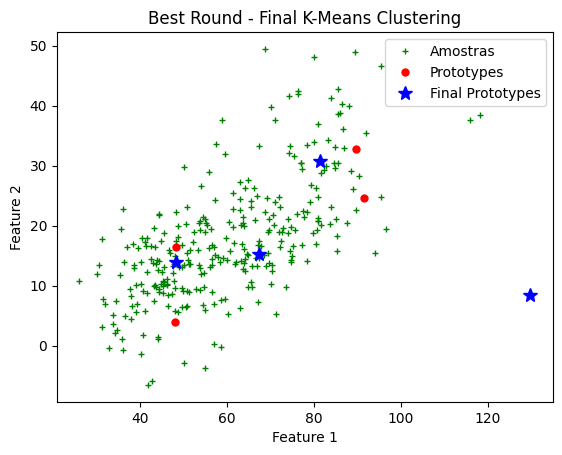

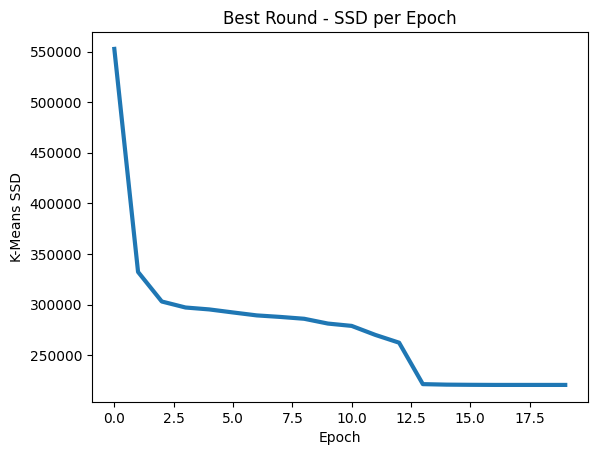

In [175]:
# Usando o Melhor K segundo o Índice de Calinski-Harabasz
best_index_prototypes = best_prototypes[best_ch_idx]
best_index_final_prototypes = best_final_prototypes[best_ch_idx]
best_index_ssd = best_ssds[best_ch_idx]

print("Best K =", best_ch_idx+2)
print("Best SSD =", best_index_ssd[-1])

# Mostra a curva de CH x K
plt.figure()
plt.plot(range(2,11), best_chs, linewidth=3)
plt.xlabel('K')
plt.ylabel('Calinski-Harabasz')
plt.title('Calinski-Harabasz Index')
plt.show()

# Mostra a curva de CH x K
plt.figure()
plt.plot(range(2,11), best_dbs, linewidth=3)
plt.xlabel('K')
plt.ylabel('Davies-Bouldin')
plt.title('Davies-Bouldin Index')
plt.show()

# Mostra posição final dos protótipos
plt.figure()
# vor = Voronoi(kmeans_prototypes[:,:2])
# fig = voronoi_plot_2d(vor)
plt.plot(data[:, 0], data[:, 1], '+g', markersize=5)
plt.plot(best_index_prototypes[:, 0], best_index_prototypes[:, 1], '.r', markersize=10)
plt.plot(best_index_final_prototypes[:, 0], best_index_final_prototypes[:, 1], 'b*', markersize=10)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Best Round - Final K-Means Clustering')
plt.legend(['Amostras', 'Prototypes', 'Final Prototypes'])
plt.show()

# Mostra evolução do SSD ao longo das épocas de treinamento
plt.figure()
plt.plot(best_index_ssd, linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('K-Means SSD')
plt.title('Best Round - SSD per Epoch')
plt.show()

Melhor SSD K-Medians: 532138.7121000001 (na Rodada 6)


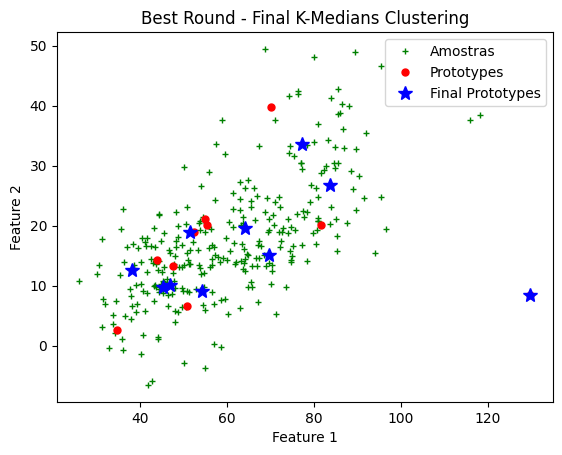

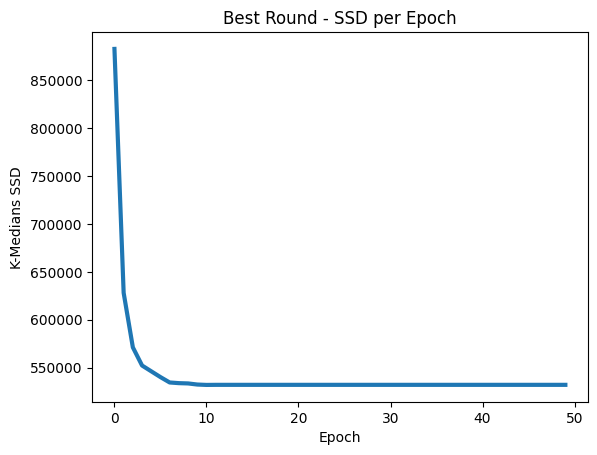

In [140]:
# Batch K-medians
def kmedians(data, proto, epochs):
    N, p = data.shape
    K = proto.shape[0]
    SSD = np.zeros(epochs)
    
    updt_proto = np.copy(proto)
    
    for epoch in range(epochs):
        dist = np.zeros((N, K))
        for t in range(N):
            dist[t, :] = np.sum(np.abs(data[t, :] - updt_proto), axis=1)
        
        cluster = np.argmin(dist, axis=1)
    
        SSD[epoch] = np.sum(np.min(dist, axis=1)**2)
    
        for k in range(K):
            I = np.where(cluster == k)[0]
            partition = data[I, :]
            updt_proto[k, :] = np.median(partition, axis=0)

    return updt_proto, SSD

# Aplicando K-medianas nos dados por rodada
rnd_prototypes, rnd_final_prototypes, rnd_ssds = [], [], []
for rnd in range(rounds):
    idxs = np.random.choice(data.shape[0], K, replace=False) # Aleatoriedade dos protótipos
    prototypes = data[idxs, :] # Protótipos definidos
    rnd_prototypes.append(prototypes)
    
    prototypes, kmedians_SSD = kmedians(data, prototypes, epochs)
    
    rnd_final_prototypes.append(prototypes)
    rnd_ssds.append(kmedians_SSD)

best_ssd_idx = np.argmin([ssd[-1] for ssd in rnd_ssds]) # Pega o índice da rodada com menor SSD final

best_prototypes = rnd_prototypes[best_ssd_idx]
best_final_prototypes = rnd_final_prototypes[best_ssd_idx]
best_ssd = rnd_ssds[best_ssd_idx]

print("Melhor SSD K-Medians: {} (na Rodada {})".format(best_ssd[-1], best_ssd_idx))

# Mostra posição final dos protótipos
plt.figure()
# vor = Voronoi(kmedians_prototypes[:,:2])
# fig = voronoi_plot_2d(vor)
plt.plot(data[:, 0], data[:, 1], '+g', markersize=5)
plt.plot(best_prototypes[:, 0], best_prototypes[:, 1], '.r', markersize=10)
plt.plot(best_final_prototypes[:, 0], best_final_prototypes[:, 1], 'b*', markersize=10)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Best Round - Final K-Medians Clustering')
plt.legend(['Amostras', 'Prototypes', 'Final Prototypes'])
plt.show()

# Mostra evolução do SSD ao longo das épocas de treinamento
plt.figure()
plt.plot(best_ssd, linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('K-Medians SSD')
plt.title('Best Round - SSD per Epoch')
plt.show()

In [141]:
from sklearn.metrics import pairwise_distances

def dunn_index(X, Icluster):
    """
    Índice de Validação Dunn para avaliação de clusters.
    Quanto maior o valor, melhor.

    Parameters:
    - X: Conjunto de dados.
    - Icluster: Vetor de índices de cluster atribuídos a cada ponto.

    Returns:
    - Dunn Index.
    """
    num_clusters = len(np.unique(Icluster))
    if num_clusters == 1:
        return np.inf
    
    min_intercluster_distance = np.inf
    max_intracluster_diameter = 0

    for i in range(1, num_clusters + 1):
        cluster_points = X[Icluster == i]
        intracluster_distances = pairwise_distances(cluster_points)
        max_intracluster_diameter = max(np.max(intracluster_distances), max_intracluster_diameter)

        for j in range(i + 1, num_clusters + 1):
            other_cluster_points = X[Icluster == j]
            intercluster_distance = np.min(pairwise_distances(cluster_points, other_cluster_points))
            min_intercluster_distance = min(min_intercluster_distance, intercluster_distance)

    dunn_index = min_intercluster_distance / max_intracluster_diameter
    return dunn_index

def davies_bouldin_index(X, Icluster):
    """
    Índice de Validação Davies-Bouldin para avaliação de clusters.
    Quanto menor o valor, melhor.

    Parameters:
    - X: Conjunto de dados.
    - Icluster: Vetor de índices de cluster atribuídos a cada ponto.

    Returns:
    - Davies-Bouldin Index.
    """
    num_clusters = len(np.unique(Icluster))
    if num_clusters == 1:
        return 0.0

    centroids = [np.mean(X[Icluster == i], axis=0) for i in range(1, num_clusters + 1)]

    # Calcula as distâncias médias intracluster
    avg_intracluster_distances = []
    for i in range(num_clusters):
        cluster_points = X[Icluster == i + 1]
        intracluster_distances = pairwise_distances(cluster_points, [centroids[i]])
        avg_intracluster_distances.append(np.mean(intracluster_distances))

    # Calcula as distâncias médias intercluster normalizadas
    intercluster_distances = pairwise_distances(centroids)
    normalized_intercluster_distances = (intercluster_distances + intercluster_distances.T) / avg_intracluster_distances

    # Ignora a diagonal principal (distâncias intracluster)
    np.fill_diagonal(normalized_intercluster_distances, np.inf)

    davies_bouldin_index = np.max(np.sum(normalized_intercluster_distances, axis=1)) / num_clusters
    return davies_bouldin_index

def calinski_harabasz_index(X, Icluster):
    """
    Índice de Validação Calinski-Harabasz para avaliação de clusters.
    Quanto maior o valor, melhor.

    Parameters:
    - X: Conjunto de dados.
    - Icluster: Vetor de índices de cluster atribuídos a cada ponto.

    Returns:
    - Calinski-Harabasz Index.
    """
    num_clusters = len(np.unique(Icluster))
    if num_clusters == 1:
        return np.inf

    centroids = [np.mean(X[Icluster == i], axis=0) for i in range(1, num_clusters + 1)]

    overall_centroid = np.mean(X, axis=0)

    # Calcula a soma dos quadrados intracluster
    within_cluster_ss = sum(np.sum(pairwise_distances(X[Icluster == i]) ** 2) for i in range(1, num_clusters + 1))

    # Calcula a soma dos quadrados intercluster
    between_cluster_ss = sum(len(X[Icluster == i]) * np.sum((centroids[i - 1] - overall_centroid) ** 2) for i in range(1, num_clusters + 1))

    # Calcula o número total de pontos
    total_points = X.shape[0]

    # Calcula o número total de clusters
    total_clusters = num_clusters

    # Calcula o Calinski-Harabasz Index
    calinski_harabasz_index = (between_cluster_ss / (total_clusters - 1)) / (within_cluster_ss / (total_points - total_clusters))
    return calinski_harabasz_index

In [142]:
# Após o treinamento do K-médias
print(Icluster)
Icluster = np.argmin(Dist2, axis=1) + 1  # Supondo que os índices de cluster começam em 1

# Calcular índices de validação
dunn = dunn_index(data, Icluster)
davies_bouldin = davies_bouldin_index(data, Icluster)
calinski_harabasz = calinski_harabasz_index(data, Icluster)

print("Dunn Index:", dunn)
print("Davies-Bouldin Index:", davies_bouldin)
print("Calinski-Harabasz Index:", calinski_harabasz)

NameError: name 'Icluster' is not defined